Задание Light:

Поставить TF Serving на свой ПК (используя docker Windows: https://docs.docker.com/docker-for-windows/install/ ; Mac: https://docs.docker.com/docker-for-mac/install/; CentOS: https://docs.docker.com/install/linux/docker-ce/centos/ -см другие дистрибутивы Linux по ссылке https://docs.docker.com/install/linux/docker-ce/ )

Обучить модель mnist Keras, сохранить в формат SavedModel

Запустить Tensor flow serving, используя docker, указав путь к модели

Вывести сигнатуру для сконвертированной модели

Написать любую функцию используя numpy, переписать функцию, используя numba (@jit decorator), таким образом чтобы версия numba работала быстрее. 

Для Заданий 1,2,3 в отчете предоставить скриншоты. задание 4 и 5 оформить в виде ноутбука.

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle

kaggle.json


#Mnist model

In [4]:
!kaggle competitions download -c digit-recognizer

 89% 65.0M/73.2M [00:00<00:00, 156MB/s]
100% 73.2M/73.2M [00:00<00:00, 165MB/s]
 76% 37.0M/48.8M [00:00<00:00, 49.7MB/s]
100% 48.8M/48.8M [00:00<00:00, 71.4MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 77.6MB/s]


In [0]:
import random
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [0]:
from numpy.random import seed
seed(13)
from tensorflow import set_random_seed
set_random_seed(666)


batch_size=256

#prepare train, val, test
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')
x_train = train_dataset[:, 1:]
y_train = train_dataset[:, 0]

# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
#x_train /= 255.0
y_train = utils.to_categorical(y_train)

random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)


test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)
#x_test = x_test / 255.0

batch_size=256

#prepare train, val, test
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')
x_train = train_dataset[:, 1:]
y_train = train_dataset[:, 0]

x_train = x_train.reshape((x_train.shape[0], -1))

input_shape = (28, 28, 1)




In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

Y_train = utils.to_categorical(Y_train)
Y_val = utils.to_categorical(Y_val)

In [0]:
params = {'activation': 'relu', 'batch_size': 256, 'drop1': 0.5, 'drop2': 0.3, 'nb_neurons': 192, 'optimizer': 'nadam'}
def create_model(params, nb_classes=10):
  model = Sequential()
  model.add(Conv2D(filters = 32, name='conv1', kernel_size = (5,5),padding = 'Same', activation =params['activation'], input_shape = (28,28,1)))
  model.add(Conv2D(filters = 32, name='conv2', kernel_size = (5,5),padding = 'Same', activation =params['activation']))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(params['drop1']))


  model.add(Conv2D(filters = 64, name='conv3', kernel_size = (3,3),padding = 'Same', activation =params['activation']))
  model.add(Conv2D(filters = 64, name='conv4', kernel_size = (3,3),padding = 'Same', activation =params['activation']))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(params['drop1']))

  model.add(Flatten())
  model.add(Dense(params['nb_neurons'], name='fc1', activation = params['activation']))
  model.add(Dropout(params['drop2']))
  model.add(Dense(nb_classes, name='fc2', activation = "softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=params['optimizer'], metrics=["accuracy"])  
  
  return model

model = create_model(params)

In [13]:
history = model.fit(X_train, Y_train, 
          batch_size=params['batch_size'],
          epochs=1,
          verbose=1,
          validation_data=(X_val, Y_val) )

model.save('model.h5')

Train on 37800 samples, validate on 4200 samples
37800/37800 [==============================] - 7s 177us/sample - loss: 0.5702 - acc: 0.8388 - val_loss: 0.8108 - val_acc: 0.9705


In [0]:
from google.colab import files
files.download('saved_models.zip')

## SavedModel

In [22]:
#!mkdir models
import tensorflow as tf
saved_model_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")

#!ls saved_models
#!zip -r saved_models saved_models

  adding: saved_models/ (stored 0%)
  adding: saved_models/assets/ (stored 0%)
  adding: saved_models/assets/saved_model.json (deflated 87%)
  adding: saved_models/variables/ (stored 0%)
  adding: saved_models/variables/checkpoint (deflated 37%)
  adding: saved_models/variables/variables.index (deflated 68%)
  adding: saved_models/variables/variables.data-00001-of-00002 (deflated 82%)
  adding: saved_models/variables/variables.data-00000-of-00002 (deflated 7%)
  adding: saved_models/saved_model.pb (deflated 89%)


In [0]:
files.upload()

#Docker

##deploy

In [0]:
: create virtual network
docker network create mnist-net
: run tensorflow container
docker run -d --restart unless-stopped -p 8500:8500 -v %cd%/saved_models:/saved_models -t --net=mnist-net --name=dckr7 tensorflow/serving:latest  

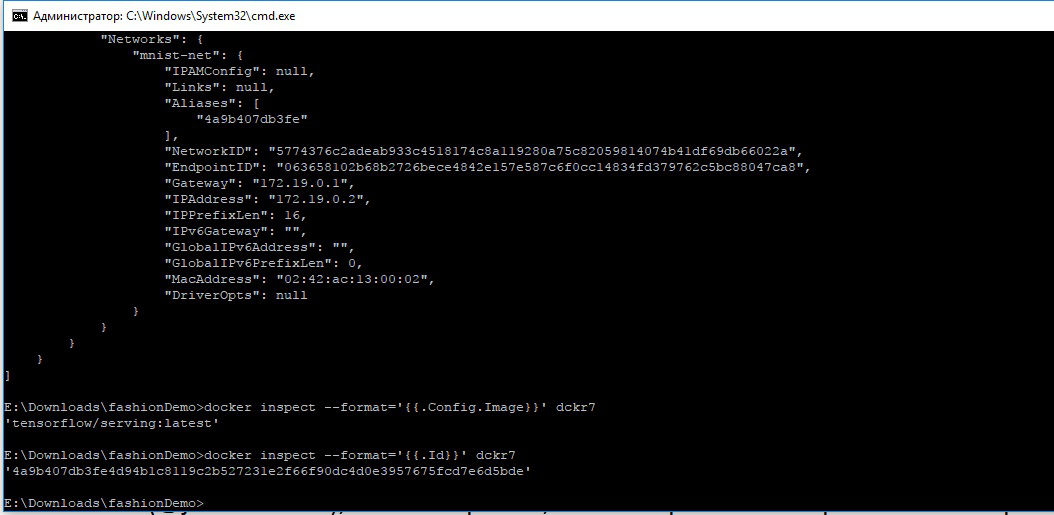

In [26]:
from PIL import Image
Image.open('serv.jpg')

#numba

In [0]:

arr1 = np.random.randint(0,10,1000000)
arr2 = np.random.randint(0,10,1000000)

def find():  
  return np.where(arr1==arr2)

In [95]:
%timeit find

10000000 loops, best of 3: 55.2 ns per loop


In [0]:
# Numba decorator
from numba import jit

@jit(nopython=True)
def find():  
  return np.where(arr1==arr2)

In [98]:
%timeit find

10000000 loops, best of 3: 48.6 ns per loop
